# From `zipline` to `pyfolio`

[Pyfolio](http://quantopian.github.io/pyfolio/) facilitates the analysis of portfolio performance and risk in-sample and out-of-sample using many standard metrics. It produces tear sheets covering the analysis of returns, positions, and transactions, as well as event risk during periods of market stress using several built-in scenarios, and also includes Bayesian out-of-sample performance analysis.

* Open-source backtester by Quantopian Inc.
* Powers Quantopian.com
* State-of-the-art portfolio and risk analytics
* Various models for transaction costs and slippage.
* Open source and free: Apache v2 license
* Can be used:
   - stand alone
   - with Zipline
   - on Quantopian

## Imports & Settings

In [26]:
import warnings
warnings.filterwarnings('ignore')

In [27]:
%matplotlib inline
from pathlib import Path

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyfolio.utils import extract_rets_pos_txn_from_zipline
from pyfolio.plotting import (plot_perf_stats,
                              show_perf_stats,
                              plot_rolling_beta,
                              plot_rolling_returns,
                              plot_rolling_sharpe,
                              plot_drawdown_periods,
                              plot_drawdown_underwater)

from pyfolio.timeseries import perf_stats, extract_interesting_date_ranges

In [28]:
sns.set_style('whitegrid')

## Converting data from zipline to pyfolio

In [29]:
with pd.HDFStore('backtests.h5') as store:
    backtest = store['backtest/equal_weight']
backtest.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1008 entries, 2013-01-02 00:00:00+00:00 to 2016-12-30 00:00:00+00:00
Data columns (total 39 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   period_open              1008 non-null   datetime64[ns, UTC]
 1   period_close             1008 non-null   datetime64[ns, UTC]
 2   gross_leverage           1008 non-null   float64            
 3   short_exposure           1008 non-null   float64            
 4   long_exposure            1008 non-null   float64            
 5   net_leverage             1008 non-null   float64            
 6   starting_exposure        1008 non-null   float64            
 7   shorts_count             1008 non-null   int64              
 8   ending_value             1008 non-null   float64            
 9   starting_value           1008 non-null   float64            
 10  portfolio_value          1008 non-null   float64

`pyfolio` relies on portfolio returns and position data, and can also take into account the transaction costs and slippage losses of trading activity. The metrics are computed using the empyrical library that can also be used on a standalone basis. The performance DataFrame produced by the zipline backtesting engine can be translated into the requisite pyfolio input.

In [30]:
returns, positions, transactions = extract_rets_pos_txn_from_zipline(backtest)
returns = returns[20:] # updated to match existing backtest duration

In [31]:
returns.head().append(returns.tail())

2013-01-31 00:00:00+00:00    0.001362
2013-02-01 00:00:00+00:00   -0.000648
2013-02-04 00:00:00+00:00   -0.000612
2013-02-05 00:00:00+00:00   -0.000463
2013-02-06 00:00:00+00:00    0.000370
2016-12-23 00:00:00+00:00   -0.000233
2016-12-27 00:00:00+00:00    0.000160
2016-12-28 00:00:00+00:00   -0.000847
2016-12-29 00:00:00+00:00    0.000735
2016-12-30 00:00:00+00:00   -0.000606
Name: returns, dtype: float64

In [32]:
positions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1004 entries, 2013-01-08 00:00:00+00:00 to 2016-12-30 00:00:00+00:00
Columns: 750 entries, Equity(0 [A]) to cash
dtypes: float64(750)
memory usage: 5.8 MB


In [33]:
positions.columns = [c for c in positions.columns[:-1]] + ['cash']
positions.index = positions.index.normalize()
positions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1004 entries, 2013-01-08 00:00:00+00:00 to 2016-12-30 00:00:00+00:00
Columns: 750 entries, Equity(0 [A]) to cash
dtypes: float64(750)
memory usage: 5.8 MB


In [34]:
transactions.symbol = transactions.symbol.apply(lambda x: x.symbol)

In [35]:
transactions.head().append(transactions.tail())

,sid,symbol,price,order_id,amount,commission,dt,txn_dollars
2013-01-08 21:00:00+00:00,Equity(85 [AGN]),AGN,86.680005,af1a8ddd1d6a44688b634741f663796d,2334,None,2013-01-08 21:00:00+00:00,-202311.131306
2013-01-08 21:00:00+00:00,Equity(213 [ARIA]),ARIA,19.651001,5953dfc3f4c64559b67169ecfb802268,7590,None,2013-01-08 21:00:00+00:00,-149151.099321
2013-01-08 21:00:00+00:00,Equity(367 [BIIB]),BIIB,144.390001,1353be7cd0cc4fad8e4ccee22ff4f2ab,1365,None,2013-01-08 21:00:00+00:00,-197092.351185
2013-01-08 21:00:00+00:00,Equity(811 [DFS]),DFS,40.090001,b4c194e9518940eea50439cdee421701,5073,None,2013-01-08 21:00:00+00:00,-203376.572741
2013-01-08 21:00:00+00:00,Equity(1059 [FDO]),FDO,57.320002,959f4c840fab405997fc863c77def34a,3496,None,2013-01-08 21:00:00+00:00,-200390.728571
2016-12-29 21:00:00+00:00,Equity(66 [AEO]),AEO,15.270000,7b0d0ed80d134327ae683faed462783a,3461,None,2016-12-29 21:00:00+00:00,-52849.470534
2016-12-29 21:00:00+00:00,Equity(833 [DKS]),DKS,52.380000,33f25c14baa94447a1167c0de787f531,1063,None,2016-12-29 21:00:00+00:00,-55679.940343
2016-12-29 21:00:00+00:00,Equity(1757 [MAT]),MAT,27.630000,5497cdd5283444e1b4cb995e9700877d,1183,None,2016-12-29 21:00:00+00:00,-32686.290035
2016-12-30 21:00:00+00:00,Equity(2181 [PDCO]),PDCO,41.030000,780fac6b79354ff7bd07e0c1da5edbca,-119,None,2016-12-30 21:00:00+00:00,4882.569999
2016-12-30 21:00:00+00:00,Equity(2953 [URBN]),URBN,28.480000,dc0d200982404681b5833d741781e603,-1006,None,2016-12-30 21:00:00+00:00,28650.879685


In [36]:
HDF_PATH = Path('..', 'data', 'assets.h5')

### Sector Map

In [37]:
assets = positions.columns[:-1]
with pd.HDFStore(HDF_PATH) as store:
    df = store.get('us_equities/stocks')['sector'].dropna()
    df = df[~df.index.duplicated()]
sector_map = df.reindex(assets).fillna('Unknown').to_dict()

### Benchmark

In [38]:
with pd.HDFStore(HDF_PATH) as store:
    benchmark_rets = store['sp500/fred'].close.pct_change()
benchmark_rets.name = 'S&P500'
benchmark_rets = benchmark_rets.tz_localize('UTC').filter(returns.index)
benchmark_rets.tail()

DATE
2016-12-23 00:00:00+00:00    0.001252
2016-12-27 00:00:00+00:00    0.002248
2016-12-28 00:00:00+00:00   -0.008357
2016-12-29 00:00:00+00:00   -0.000293
2016-12-30 00:00:00+00:00   -0.004637
Name: S&P500, dtype: float64

In [39]:
perf_stats(returns=returns,
           factor_returns=benchmark_rets)
#            positions=positions, 
#            transactions=transactions)

Annual return          0.016553
Cumulative returns     0.066485
Annual volatility      0.047880
Sharpe ratio           0.366811
Calmar ratio           0.283510
Stability              0.550983
Max drawdown          -0.058387
Omega ratio            1.071469
Sortino ratio          0.533579
Skew                   0.232539
Kurtosis               6.010219
Tail ratio             1.001202
Daily value at risk   -0.005963
Alpha                  0.003629
Beta                   0.122669
dtype: float64

In [40]:
returns[20:]

2013-03-01 00:00:00+00:00   -0.000204
2013-03-04 00:00:00+00:00   -0.000482
2013-03-05 00:00:00+00:00    0.000264
2013-03-06 00:00:00+00:00    0.003081
2013-03-07 00:00:00+00:00    0.000036
                               ...   
2016-12-23 00:00:00+00:00   -0.000233
2016-12-27 00:00:00+00:00    0.000160
2016-12-28 00:00:00+00:00   -0.000847
2016-12-29 00:00:00+00:00    0.000735
2016-12-30 00:00:00+00:00   -0.000606
Name: returns, Length: 968, dtype: float64

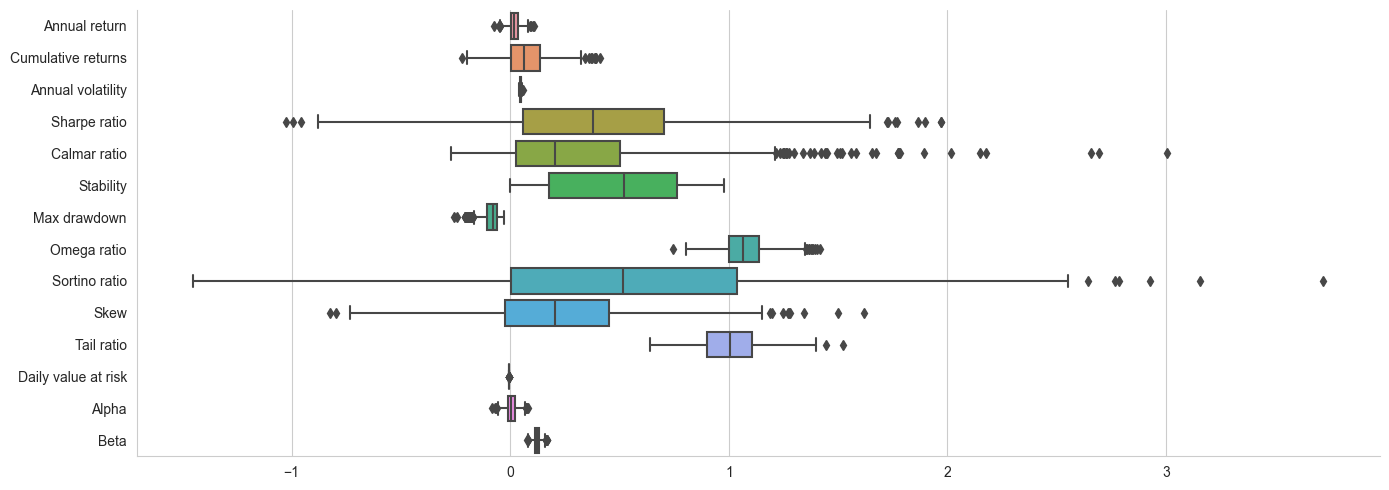

In [41]:
fig, ax = plt.subplots(figsize=(14, 5))
plot_perf_stats(returns=returns, 
                factor_returns=benchmark_rets,     
                ax=ax)
sns.despine()
fig.tight_layout();

## Returns Analysis

Testing a trading strategy involves backtesting against historical data to fine-tune alpha factor parameters, as well as forward-testing against new market data to validate that the strategy performs well out of sample or if the parameters are too closely tailored to specific historical circumstances.

Pyfolio allows for the designation of an out-of-sample period to simulate walk-forward testing. There are numerous aspects to take into account when testing a strategy to obtain statistically reliable results, which we will address here. 

In [42]:
oos_date = '2016-01-01'

In [43]:
show_perf_stats(returns=returns, 
                factor_returns=benchmark_rets, 
                positions=positions, 
                transactions=transactions, 
                live_start_date=oos_date)

### Rolling Returns OOS

The `plot_rolling_returns` function displays cumulative in and out-of-sample returns against a user-defined benchmark (we are using the S&P 500):


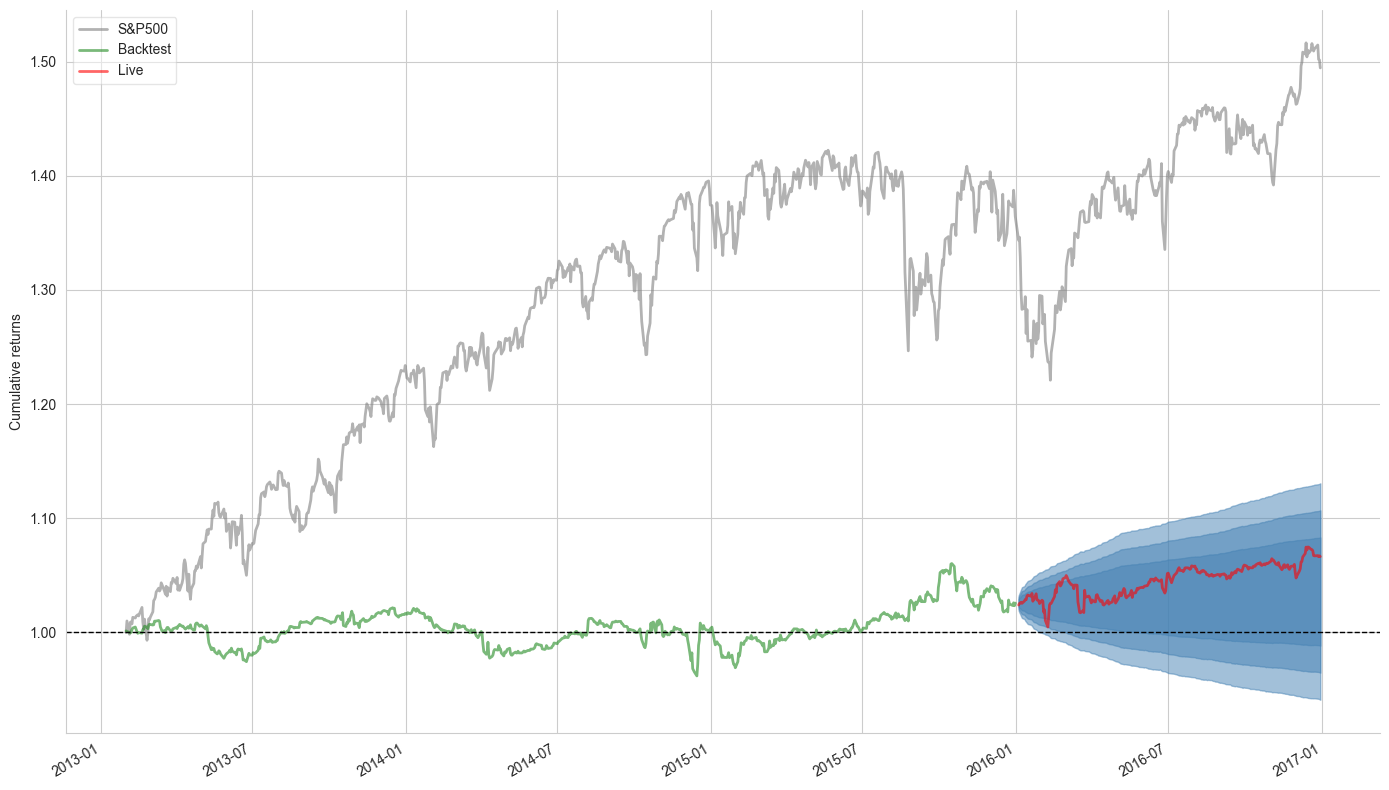

In [44]:
plot_rolling_returns(returns=returns, 
                     factor_returns=benchmark_rets, 
                     live_start_date=oos_date, 
                     cone_std=(1.0, 1.5, 2.0))
plt.gcf().set_size_inches(14, 8)
sns.despine()
plt.tight_layout();

The plot includes a cone that shows expanding confidence intervals to indicate when out-of-sample returns appear unlikely given random-walk assumptions. Here, our strategy did not perform well against the benchmark during the simulated 2017 out-of-sample period

## Summary Performance Statistics

pyfolio offers several analytic functions and plots. The perf_stats summary displays the annual and cumulative returns, volatility, skew, and kurtosis of returns and the SR. The following additional metrics (which can also be calculated individually) are most important:
- Max drawdown: Highest percentage loss from the previous peak
- Calmar ratio: Annual portfolio return relative to maximal drawdown
- Omega ratio: The probability-weighted ratio of gains versus losses for a return target, zero per default
- Sortino ratio: Excess return relative to downside standard deviation
- Tail ratio: Size of the right tail (gains, the absolute value of the 95th percentile) relative to the size of the left tail (losses, abs. value of the 5th percentile) 
- Daily value at risk (VaR): Loss corresponding to a return two standard deviations below the daily mean
- Alpha: Portfolio return unexplained by the benchmark return
- Beta: Exposure to the benchmark


### Rolling Sharpe

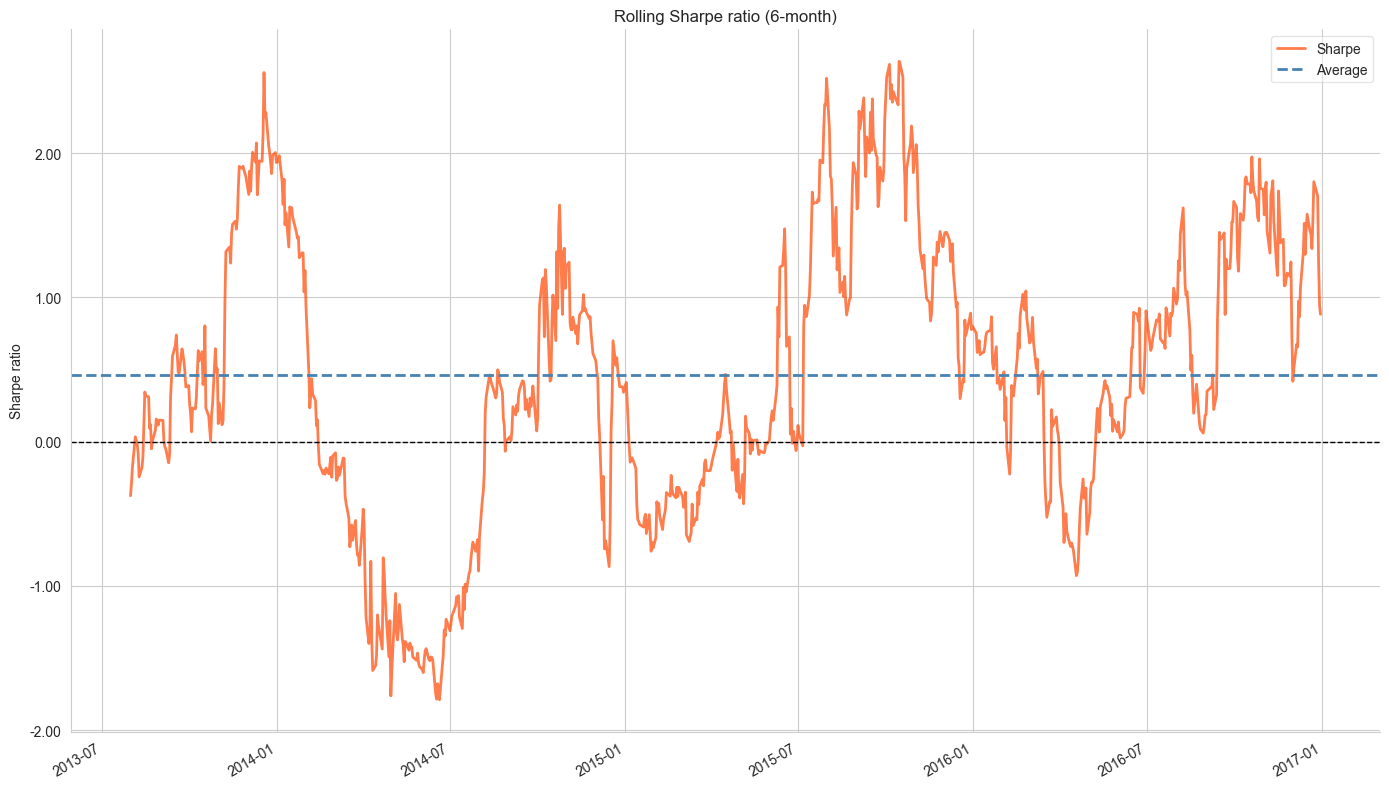

In [45]:
plot_rolling_sharpe(returns=returns)
plt.gcf().set_size_inches(14, 8)
sns.despine()
plt.tight_layout();

### Rolling Beta

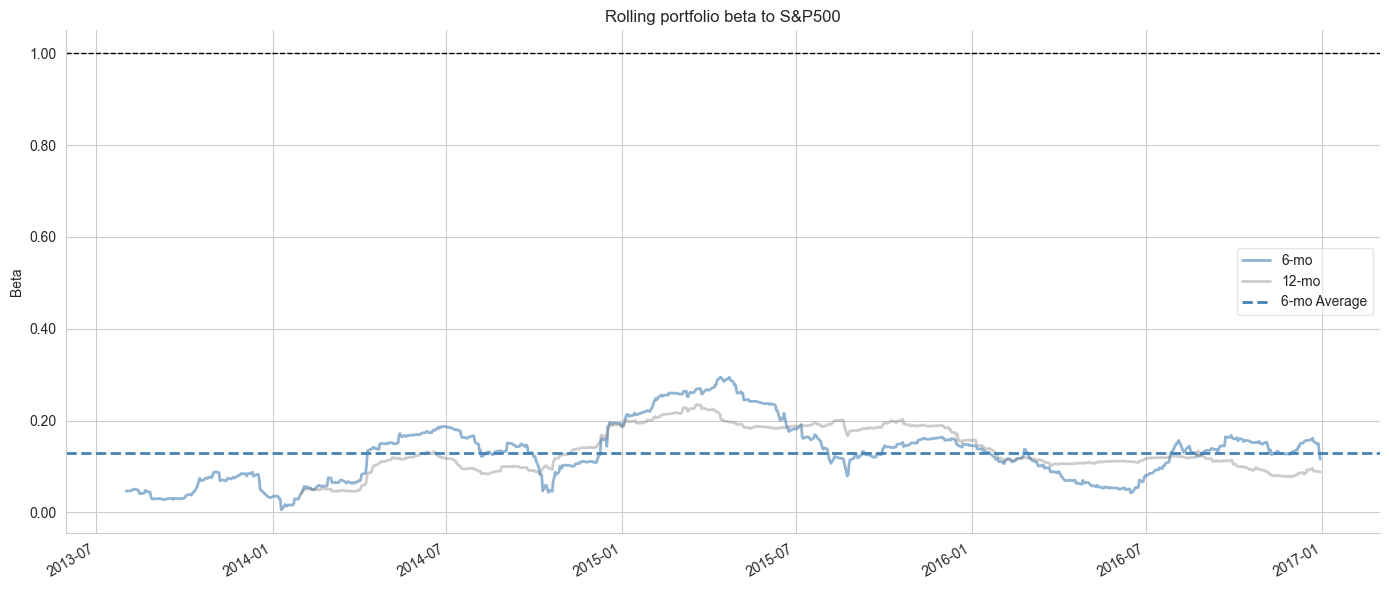

In [46]:
plot_rolling_beta(returns=returns, factor_returns=benchmark_rets)
plt.gcf().set_size_inches(14, 6)
sns.despine()
plt.tight_layout();

## Drawdown Periods

The plot_drawdown_periods(returns) function plots the principal drawdown periods for the portfolio, and several other plotting functions show the rolling SR and rolling factor exposures to the market beta or the Fama French size, growth, and momentum factors:

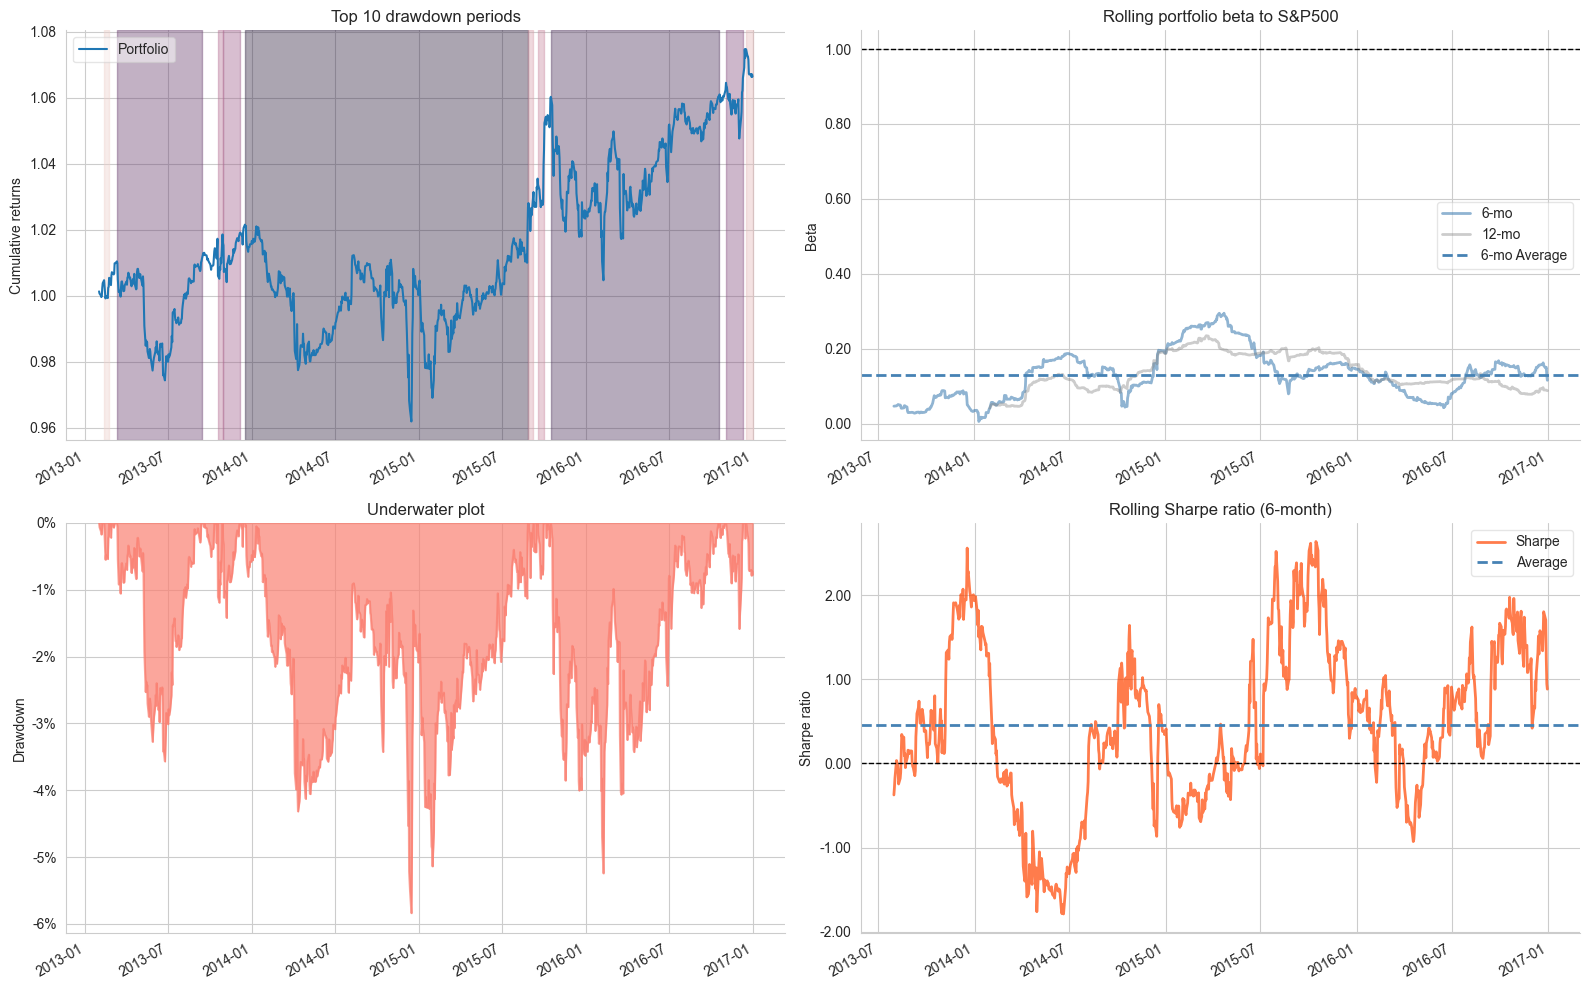

In [47]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
axes = ax.flatten()



plot_drawdown_periods(returns=returns, ax=axes[0])
plot_rolling_beta(returns=returns, factor_returns=benchmark_rets, ax=axes[1])
plot_drawdown_underwater(returns=returns, ax=axes[2])
plot_rolling_sharpe(returns=returns)
sns.despine()
plt.tight_layout();

This plot, which highlights a subset of the visualization contained in the various tear sheets, illustrates how pyfolio allows us to drill down into the performance characteristics and exposure to fundamental drivers of risk and returns.

## Modeling Event Risk

Pyfolio also includes timelines for various events that you can use to compare the performance of a portfolio to a benchmark during this period, for example, during the fall 2015 selloff following the Brexit vote.

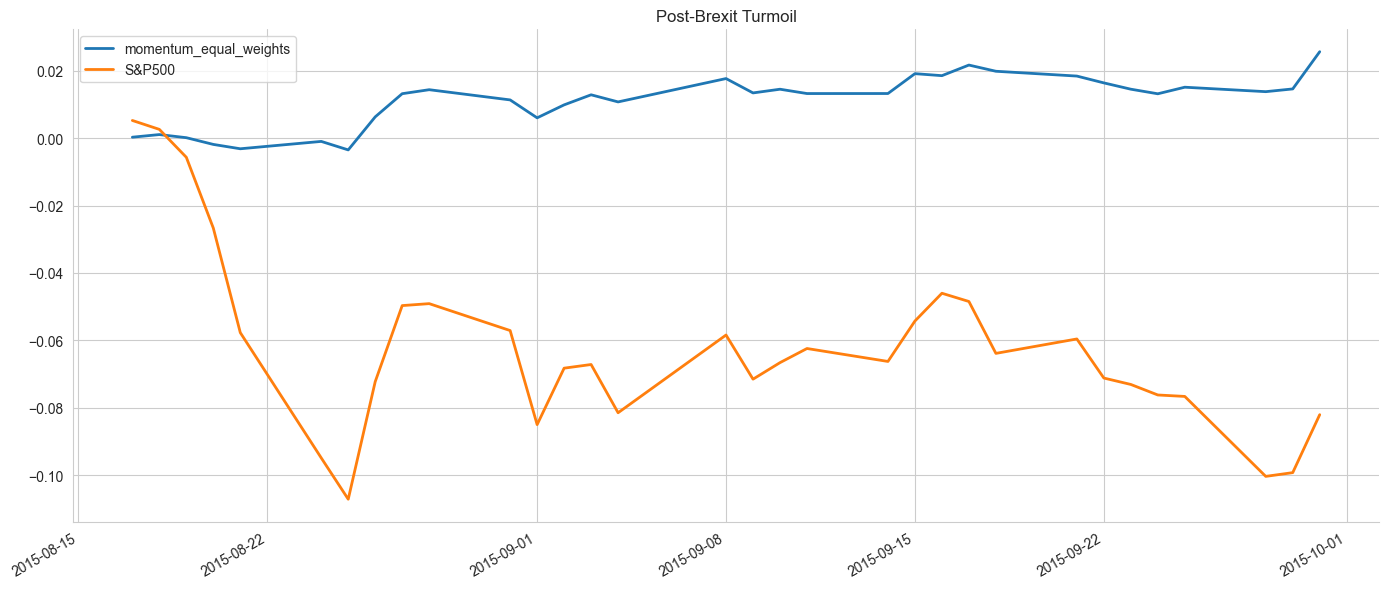

In [48]:
interesting_times = extract_interesting_date_ranges(returns=returns)
(interesting_times['Fall2015']
 .to_frame('momentum_equal_weights').join(benchmark_rets)
 .add(1).cumprod().sub(1)
 .plot(lw=2, figsize=(14, 6), title='Post-Brexit Turmoil'))
sns.despine()
plt.tight_layout();